In [2]:
# install packages in libs (as editable)
!python -m pip install -e ../libs

70.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Obtaining file:///Users/n0c09jf/code/github/binsense/libs
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for binsense-libs (pyproject.toml) ... done
  Created wheel for binsense-libs: filename=binsense_libs-0.0.1-py2.py3-none-any.whl size=1137 sha256=8524b93cea3793ac8f93136a46b3b775f211868867a04c7e319690205c497b92
  Stored in directory: /private/var/folders/vm/2g2pvy116zzglvllmm0n_f100000gx/T/pip-ephem-wheel-cache-ibxzsdqi/wheels/77/72/16/1e76e1dcd0e567ae2a1096c6d731674e5dee84ed8ab15b770d
Successfully built binsense-libs
  Attempting uninstall: binsense-libs
    Found existing installation: binsense-libs 0.0.1
    Uninstalling binsense-libs-0.0.1:
      Successfully uninstalled binsense-libs-0.0.1


In [1]:
from binsense.config import DATA_DIR
print(DATA_DIR)

import binsense.downloader as d
d.download()

import binsense.metadata as m
bin_df, item_df = m.load()
print(bin_df.shape, item_df.shape)


/Users/n0c09jf/code/github/binsense/_data


loading bin-metadata: 100%|██████████| 3875/3875 [00:43<00:00, 90.09it/s] 

(3875, 6) (10144, 12)


In [1]:
from binsense.owlv2 import hugg_loader as l
from binsense.owlv2 import Owlv2Config
from binsense.owlv2 import Owlv2ForObjectDetection, Owlv2ImageProcessor
from matplotlib import pyplot as plt
import PIL
import numpy as np
import cv2 as cv

# draws the bounding boxes on the cv image
# and plots it in the grid with each image+bbox per grid
def show_bbox_ingrid(cv_img, box_scores, grid, title=None):
    rows, cols = grid
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    for i in range(0, rows):
        for j in range(0, cols):
            bi = i*cols+j
            if bi >= len(box_scores):
                continue
            
            draw_img = cv_img.copy()
            box = [int(k) for k in box_scores[bi][0].tolist()]
            draw_img = cv.rectangle(draw_img, box[:2], box[2:], (0,0,255), 5)
            if box[3] + 25 > cv_img.shape[0]:
                y = box[3] - 10
            else:
                y = box[3] + 25
            axs[i][j].imshow(draw_img, cmap = plt.cm.Spectral)
            axs[i][j].text(0, 0,
                f'Score: {box_scores[bi][1]:1.3f}',
                ha='left',
                va='top',
                color='black',
                bbox={
                    'facecolor': 'white',
                    'alpha': 0,
                    # 'edgecolor': 'lime',
                    'boxstyle': 'square,pad=.1',
                })
    if title:
        fig.suptitle(title)
    plt.show()

processor = Owlv2ImageProcessor(**l.load_owlv2processor_config())
model = Owlv2ForObjectDetection(Owlv2Config(**l.load_owlv2model_config()))
model.load_state_dict(l.load_owlv2model_statedict())
model.eval()
print()

In [3]:
import torch
import PIL

sample_image = PIL.Image.open('../docs/sample_bin.jpg')
image_pixels = processor.preprocess(sample_image)['pixel_values']

with torch.no_grad():
    image_embeds, _ = model.image_embedder(image_pixels)
    bbox_logits  = model.objectness_predictor(image_embeds)
    bboxes = model.box_predictor(image_embeds)
    print('embeds=', image_embeds.shape, ', bbox_logits=', bbox_logits.shape, ', bboxes=',  bboxes.shape)

embeds torch.Size([1, 3600, 768]) bbox_logits torch.Size([1, 3600]) bboxes torch.Size([1, 3600, 4])


Index: 1385
Objectness: 0.43117407
box: [ 49.50325  53.09369 522.6806  885.2884 ]
Index: 1721
Objectness: 0.24492984
box: [512.2211   50.14415 699.8531  678.14795]
Index: 1965
Objectness: 0.23443286
box: [679.64795   65.144806 838.65466  721.9782  ]
Index: 2787
Objectness: 0.20877641
box: [-2.4885178e-01  6.0956195e+02  8.4352246e+02  7.6593011e+02]
Index: 3360
Objectness: 0.29632783
box: [ -2.800541 -19.532404 844.52856  920.63153 ]


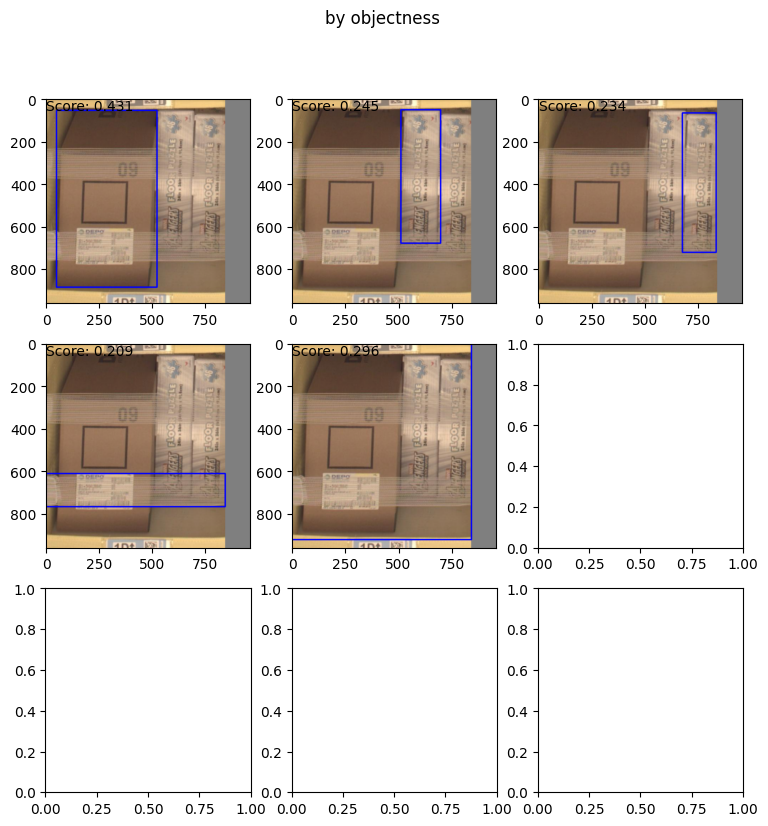

In [ ]:
import torch
from scipy.special import expit as sigmoid

padded_item_image = PIL.Image.fromarray(processor.unnormalize_pixels(image_pixels)[0])
target_sizes = torch.Tensor([padded_item_image.size[::-1]])
boxes = processor.post_process_bounding_boxes(boxes=bboxes, target_sizes=target_sizes)
boxes = np.array(boxes[0].detach())
objectnesses = np.array(bbox_logits[0].detach())

# Plot top k objects on Query Item Image
top_k = 5
objectnesses = sigmoid(objectnesses)
objectness_threshold = np.partition(objectnesses, -top_k)[-top_k]

box_scores = []
for i, (box, objectness) in enumerate(zip(boxes, objectnesses)):
  if objectness < objectness_threshold:
    continue
  
  box_scores.append((box, objectness))
  print("Index:", i)
  print("Objectness:", objectness)
  print("box:", box)

show_bbox_ingrid(np.array(padded_item_image), box_scores, grid=(3, 3), title="by objectness")